In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_STATE = 42
DATA_PATH = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [3]:
file_paths = []
labels = []

classes = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
classes.sort()

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
print(f"Class mapping: {class_to_idx}")

for class_name in classes:
    class_path = os.path.join(DATA_PATH, class_name, 'images')
    if not os.path.exists(class_path):
        continue
        
    image_files = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images in {class_name}")
    
    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        file_paths.append(img_path)
        labels.append(class_to_idx[class_name])
    
print(f"\nDataset created: {len(file_paths)} image paths")

Class mapping: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Found 3616 images in COVID
Found 6012 images in Lung_Opacity
Found 10192 images in Normal
Found 1345 images in Viral Pneumonia

Dataset created: 21165 image paths


In [4]:
# Splitting files
paths_temp, paths_test, labels_temp, labels_test = train_test_split(
    file_paths, labels, test_size=0.15, random_state=RANDOM_STATE, stratify=labels
)

paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_temp, labels_temp, test_size=0.176, random_state=RANDOM_STATE, stratify=labels_temp
)

print(f"\nDataset splits:")
print(f"Train: {len(paths_train)} samples")
print(f"Validation: {len(paths_val)} samples")
print(f"Test: {len(paths_test)} samples")


Dataset splits:
Train: 14823 samples
Validation: 3167 samples
Test: 3175 samples


In [6]:
# data load functions
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32') / 255.0
        return img
    return None

def load_batch_images(paths, labels, batch_size=32):
    images = []
    batch_labels = []
    
    for i, (path, label) in enumerate(zip(paths[:batch_size], labels[:batch_size])):
        img = load_and_preprocess_image(path)
        if img is not None:
            images.append(img)
            batch_labels.append(label)
    
    return np.array(images), np.array(batch_labels)

def create_tf_dataset(file_paths, labels, batch_size, is_training=True):
    
    def parse_image(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [15]:
# Convert labels to categorical 
num_classes = len(classes)
labels_train_cat = to_categorical(labels_train, num_classes)
labels_val_cat = to_categorical(labels_val, num_classes)
labels_test_cat = to_categorical(labels_test, num_classes)

# TF datasets
train_dataset = create_tf_dataset(paths_train, labels_train_cat, BATCH_SIZE, is_training=True)
val_dataset = create_tf_dataset(paths_val, labels_val_cat, BATCH_SIZE, is_training=False)

print(f"TF datasets created")

TF datasets created


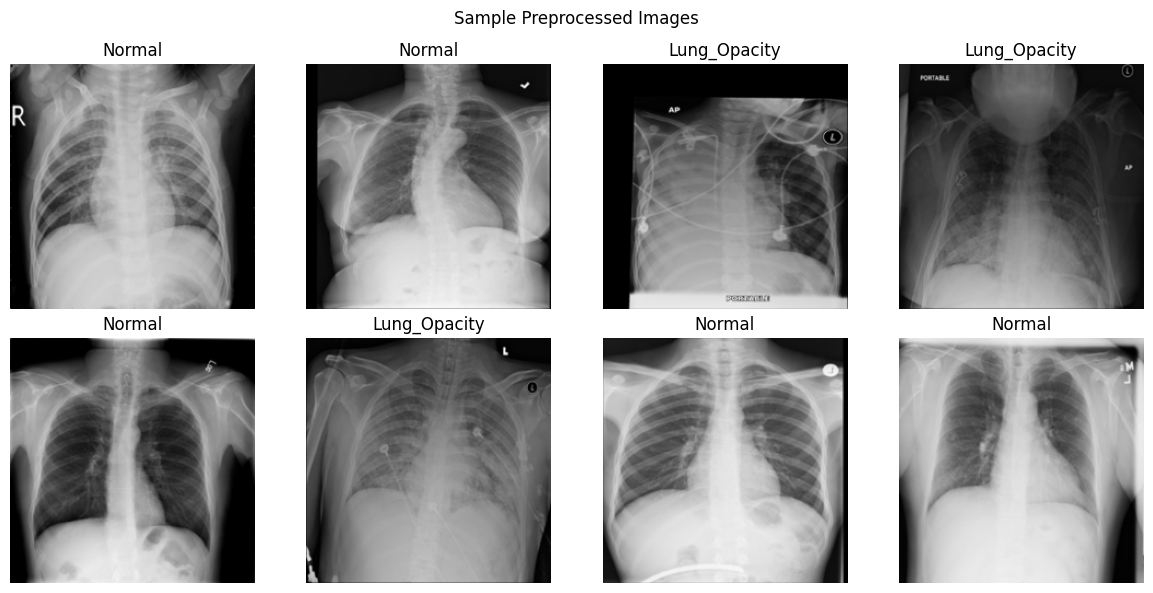

In [11]:
# sample images 
sample_images, sample_labels = load_batch_images(paths_train[:8], labels_train[:8], 8)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Sample Preprocessed Images')

for i in range(min(8, len(sample_images))):
    row = i // 4
    col = i % 4
    
    axes[row, col].imshow(sample_images[i])
    axes[row, col].set_title(f'{classes[sample_labels[i]]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# augmentation
def augment_image(image, label):
   
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    
    image = tf.image.random_flip_left_right(image)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

# augmented training dataset
train_dataset_aug = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)


Class distribution in training set:
COVID: 2533 samples
Lung_Opacity: 4210 samples
Normal: 7138 samples
Viral Pneumonia: 942 samples

Class weights for balancing:
COVID: 1.46
Lung_Opacity: 0.88
Normal: 0.52
Viral Pneumonia: 3.93


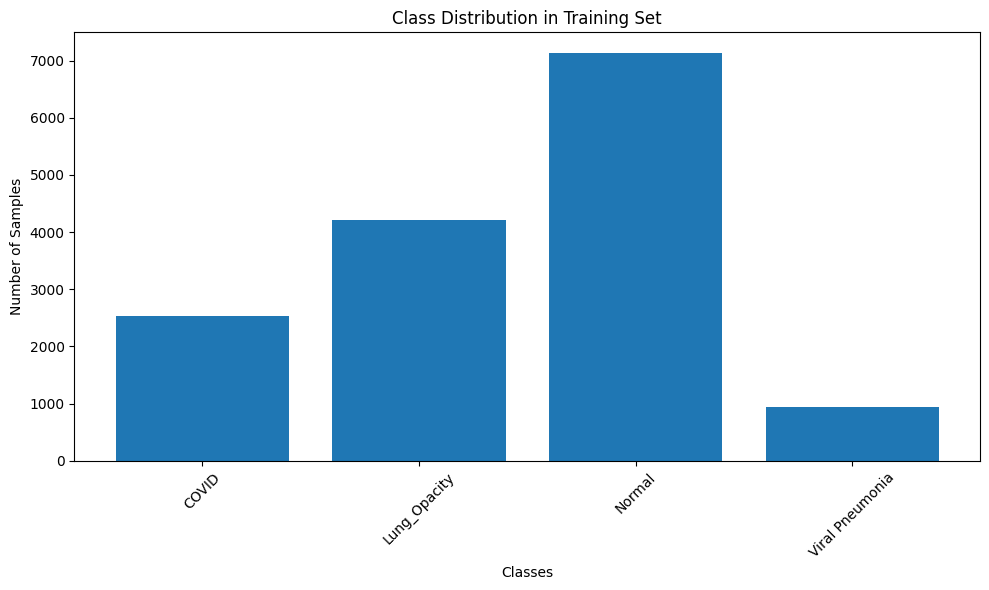

In [16]:
# Class distribution analysis
unique, counts = np.unique(labels_train, return_counts=True)
class_weights = {}
total_samples = len(labels_train)

for i, count in enumerate(counts):
    class_weights[i] = total_samples / (len(unique) * count)

print(f"\nClass distribution in training set:")
for i, (class_name, count) in enumerate(zip(classes, counts)):
    print(f"{class_name}: {count} samples")

print(f"\nClass weights for balancing:")
for i, weight in class_weights.items():
    print(f"{classes[i]}: {weight:.2f}")

plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
print(f"\nTesting dataset loading...")
batch_count = 0
for batch_images, batch_labels in train_dataset_aug.take(2):
    batch_count += 1
    print(f"Batch {batch_count}: Images shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")


Testing dataset loading...
Batch 1: Images shape: (32, 224, 224, 3), Labels shape: (32, 4)
Batch 2: Images shape: (32, 224, 224, 3), Labels shape: (32, 4)


In [18]:
# Save dataset info
import pickle

dataset_info = {
    'paths_train': paths_train,
    'paths_val': paths_val,
    'paths_test': paths_test,
    'labels_train': labels_train_cat,
    'labels_val': labels_val_cat,
    'labels_test': labels_test_cat,
    'class_names': classes,
    'class_weights': class_weights,
    'num_classes': num_classes,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE
}

with open('/kaggle/working/dataset_info.pkl', 'wb') as f:
    pickle.dump(dataset_info, f)

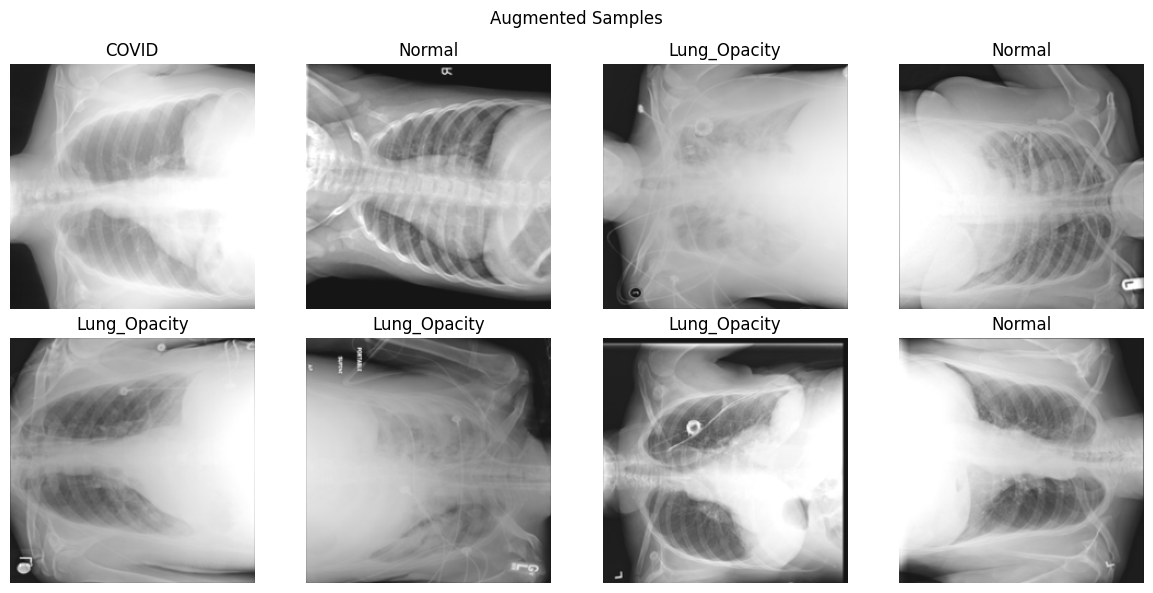

In [20]:
# augmented images
for batch_images, batch_labels in train_dataset_aug.take(1):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Augmented Samples')
    
    for i in range(8):
        row = i // 4
        col = i % 4
        
        axes[row, col].imshow(batch_images[i])
        label_idx = np.argmax(batch_labels[i])
        axes[row, col].set_title(f'{classes[label_idx]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    break